In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd

# Data Process

In [2]:
loaded_train = np.load("./problem1-DNN/train.npz")
loaded_test = np.load("./problem1-DNN/test.npz")
X_train, y_train = loaded_train["image"].reshape(-1,784), loaded_train["label"]
X_test, y_test = loaded_test["image"].reshape(-1,784), loaded_test["label"]

# one-hot
y_train_labels = np.zeros((12000, 10))
for i in range(12000):
    y_train_labels[i, int(y_train[i])] = 1
y_test_lables = np.zeros((5768, 10))
for i in range(5768):
    y_test_lables[i, int(y_test[i])] = 1

X_train, y_train, X_test, y_test = X_train/255, y_train_labels, X_test/255, y_test_lables

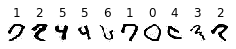

In [3]:
for i in range(10):
    plt.subplot(1,15,i+1)
    plt.imshow(loaded_train["image"][i], cmap=plt.cm.gray_r)
    plt.title(int(loaded_train["label"][i]))
    plt.axis("off")
plt.show()
    

# Activation Function and Cross_entropy

In [4]:
 # activation function
def sigmoid(x):
    return 1/(1 + np.exp(-x))

def sigmoid_d(x):
    return sigmoid(x) * (1-sigmoid(x))

def leakyReLU(x):
    return np.maximum(x, 0.01*x)

def leakyReLU_d(x):
    return np.where(x > 0, 1, 0.01)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis = 0))
    return exp_x / np.sum(exp_x)

# cost function
def cross_entropy(p, q): 
    return -np.sum(np.nan_to_num((p * np.log(q))))

# Class for DNN

In [5]:
class DNN:
    def __init__(self, units, initialization = "normal", 
                 activation_function = leakyReLU, activation_function_derivative = leakyReLU_d):
        self.layers = len(units)
        self.units = units
        self.act_fun = activation_function
        self.act_fun_d = activation_function_derivative
        
        # initialization biases and weights
        if initialization == "normal":
            self.biases = [np.random.normal(0, 0.001, size = (1, y)) for y in units[1:]]
            self.weights = [np.random.normal(0, 0.001, size = (x, y)) for x, y in zip(units[:-1], units[1:])]
        if initialization == "zero":
            self.biases = [np.zeros((1, y)) for y in units[1:]]
            self.weights = [np.zeros((x , y)) for x, y in zip(units[:-1], units[1:])]
        if initialization == "uniform":
            self.biases = [np.random.uniform(-1/np.sqrt(784), 1/np.sqrt(784), size = (1, y)) \
                           for y in units[1:]]
            self.weights = [np.random.uniform(-1/np.sqrt(784), 1/np.sqrt(784), size = (x, y)) \
                            for x, y in zip(units[:-1], units[1:])]  
        if initialization == "normal_01":
            self.biases = [np.random.normal(0, 1, size = (1, y)) for y in units[1:]]
            self.weights = [np.random.normal(0, 1, size = (x, y)) for x, y in zip(units[:-1], units[1:])]
        
        # save information
        self.training_error = []
        self.testing_error = []
        self.training_loss = []

#=====training data and update parameters=====#
    def train(self, X_train, y_train ,epochs, m, learning_rate, X_test , y_test , Adam = False):
        self.m = m
        self.t = 0
        train_size = len(X_train)
        testing_size = len(X_test)
        
        for epoch in range(epochs):
            if Adam:
                # initialize parameters for adam every epoch
                self.m_w = [np.zeros((x , y)) for x, y in zip(self.units[:-1], self.units[1:])]
                self.v_w = [np.zeros((x , y)) for x, y in zip(self.units[:-1], self.units[1:])]
                self.m_b = [np.zeros((1, y)) for y in self.units[1:]]
                self.v_b = [np.zeros((1, y)) for y in self.units[1:]]
                self.m += 1
                
            # random select m data
            ind = np.random.permutation(range(len(X_train)))
            for i in range(0, train_size, m):
                mini_batch_ind = ind[i : i+m]
                X_mini_batch = X_train[mini_batch_ind]
                y_mini_batch = y_train[mini_batch_ind]
                
                # caculate delta with mini_batch
                gradient_w, gradient_b = self.backProp(X_mini_batch, y_mini_batch)
                
                # update weights and biases
                if Adam:
                    ms_w, vs_w, ms_b, vs_b = self.adam(gradient_w, gradient_b)
                    for l, m_w, v_w, m_b, v_b in zip(range(self.layers-1), ms_w, vs_w, ms_b, vs_b ):
                        self.weights[l] -= learning_rate * (m_w/(np.sqrt(v_w) + 10e-8))
                        self.biases[l] -= learning_rate * (m_b/(np.sqrt(v_b) + 10e-8)) 
                    
                # update weights and biases
                else:
                    for l, w, b in zip(range(self.layers),gradient_w, gradient_b):
                        self.weights[l] -= learning_rate * w
                        self.biases[l] -= learning_rate  * b  
                        
            self.training_error.append(self.countError(X_train, y_train))
            self.testing_error.append(self.countError(X_test, y_test))
            self.training_loss.append(self.countLoss(X_train, y_train))                

            print("+++Epoch+++ %d / %d" %(epoch, epochs), end = '\r')                    
            # save info for every epoch
            if ((epoch+1) % 10) == 0:            
                print("===Epoch ",epoch+1,"===")
                print("Training Error: %f, Training Loss: %f, Testing Error: %f"
                     %(self.training_error[-1], self.training_loss[-1], self.testing_error[-1]))

    def feedForward(self, x):
        for w, b in zip(self.weights, self.biases):
            z = np.dot(x, w) + b
            x = self.act_fun(z)
        output = np.apply_along_axis(softmax, 1, z)
        return output

#=====backprop=====#
    def backProp(self, x, y):
        
        # forward pass
        self.a_layers = [x]
        self.z_layers = []
        for w, b in zip(self.weights, self.biases):
            z = np.dot(x, w) + b
            self.z_layers.append(z)
            x = self.act_fun(z)
            self.a_layers.append(x)
        output_layer = np.apply_along_axis(softmax, 1, z)           
                
        # back pass
        # calculate last delta(delta_L) fitst with cross entropy
        delta = (output_layer-y) * self.act_fun_d(self.z_layers[-1])
        delta_layers = [delta]
        
        # caculate delta of L-1, L-2 ..., 2 layers
        for layer in range(self.layers-1, 1, -1):
            delta_l = np.dot(delta_layers[-1], self.weights[layer-1].T) * self.act_fun_d(self.z_layers[layer-2])
            delta_layers.append(delta_l) # layer of delta will be L, L-1, L-2
        delta_layers.reverse() # 2, 3, ..., L
        
        gradient_w = [(1/self.m) * np.dot(self.a_layers[layer].T, d) for (layer, d) in enumerate(delta_layers)]
        gradient_b = [(1/self.m) * d.sum(0).reshape(1, -1) for d in delta_layers]
            
        return (gradient_w, gradient_b)

#=====Adam=====#
    def adam(self, gradient_w, gradient_b):
    # parameter
        beta_1 = 0.9
        beta_2 = 0.999
        self.t += 1

        # caculate for weights
        for l, w, b in zip(range(self.layers), gradient_w, gradient_b):
            self.m_w[l] = (beta_1 * self.m_w[l] + (1 - beta_1) * w) / (1-beta_1**self.t)
            self.v_w[l] = (beta_2 * self.v_w[l] + (1 - beta_2) * (w * w))  / (1-beta_2**self.t)
            self.m_b[l] = (beta_1 * self.m_b[l] + (1 - beta_1) * b) / (1-beta_1**self.t)
            self.v_b[l] = (beta_2 * self.v_b[l] + (1 - beta_2) * (b * b)) / (1-beta_2**self.t)    

        return (self.m_w, self.v_w, self.m_b, self.v_b)

    def countError(self, x, y):
        # count error number
        yhat = np.argmax(self.feedForward(x),axis = 1)
        truth = np.argmax(y, axis = 1)
        return (yhat != truth).mean()
    
    def countLoss(self, x, y):
        return cross_entropy(y, self.feedForward(x))
 

# Function to Plot Error

In [6]:
def polot_error(model):
    plt.plot(model.training_error, label = "Train")
    plt.plot(model.testing_error, label = "Test")
    plt.legend()
    plt.show()

# Function to Plot Latent Features

In [7]:
def plot_latent_features(x, y, model, activation_function):   
    z_layers = []
    for w, b in zip(model.weights, model.biases):
        z = np.dot(x, w) + b
        z_layers.append(z)
        x = activation_function(z)
    z_latent = z_layers[-2].T
    # plot
    fig, ax = plt.subplots()
    scatter = ax.scatter(z_latent[0], z_latent[1], c=np.argmax(y, axis = 1))
    legend = ax.legend(*scatter.legend_elements(),
                        loc="best", title="Ground truth")
    ax.add_artist(legend)
    plt.show()


# Function to Show Confusion_matrix

In [8]:
def cfm(x, y ,model):
    yhat = np.argmax(model.feedForward(x),axis=1)
    ytrue = np.argmax(y, axis = 1)
    matrix = confusion_matrix(y_pred=yhat, y_true=ytrue)
    df_cfm = pd.DataFrame(
        matrix,
        index = [0,1,2,3,4,5,6,7,8,9],
        columns = [0,1,2,3,4,5,6,7,8,9]
    )
    print(df_cfm)
    print("Accuracy: ", matrix.diagonal().sum()/matrix.sum())    

In [ ]:
np.random.seed(42)
L4 = DNN([784,512,128,10],initialization="normal", 
           activation_function=leakyReLU, activation_function_derivative=leakyReLU_d)
L4.train(X_train, y_train, epochs= 250, m= 500, learning_rate= 1, X_test = X_test,y_test= y_test)

===Epoch  10 ===250
Training Error: 0.810583, Training Loss: 25531.592595, Testing Error: 0.815187
===Epoch  20 === 250
Training Error: 0.257667, Training Loss: 8675.458915, Testing Error: 0.266123
===Epoch  30 === 250
Training Error: 0.728000, Training Loss: 24586.079637, Testing Error: 0.733530
===Epoch  40 === 250
Training Error: 0.562083, Training Loss: 18362.684461, Testing Error: 0.562587
===Epoch  50 === 250
Training Error: 0.563250, Training Loss: 18541.250725, Testing Error: 0.560680
===Epoch  60 === 250
Training Error: 0.470083, Training Loss: 18744.329171, Testing Error: 0.478675
===Epoch  70 === 250
Training Error: 0.317833, Training Loss: 10874.117391, Testing Error: 0.318655
===Epoch  80 === 250
Training Error: 0.254917, Training Loss: 8162.648851, Testing Error: 0.252947
===Epoch  90 === 250
Training Error: 0.172750, Training Loss: 5807.234004, Testing Error: 0.178051
===Epoch  100 ===250
Training Error: 0.144917, Training Loss: 5281.853413, Testing Error: 0.158114
===Ep

In [21]:
np.random.seed(42)
L4_a = DNN([784,512,128,10],initialization="normal", 
           activation_function=leakyReLU, activation_function_derivative=leakyReLU_d)
L4_a.train(X_train, y_train, epochs= 250, m= 500, learning_rate= 0.001, X_test = X_test,y_test= y_test, Adam = True)

===Epoch  10 ===250
Training Error:  0.4871666666666667
Training Loss:  14331.128627525006
Testing Error:   0.4786754507628294
===Epoch  20 === 250
Training Error:  0.24641666666666667
Training Loss:  8452.093221933641
Testing Error:   0.24965325936199723
===Epoch  30 === 250
Training Error:  0.09016666666666667
Training Loss:  3524.43015725268
Testing Error:   0.10211511789181692
===Epoch  40 === 250
Training Error:  0.036833333333333336
Training Loss:  1530.838714300355
Testing Error:   0.05617198335644938
===Epoch  50 === 250
Training Error:  0.063
Training Loss:  2690.365111503666
Testing Error:   0.08339112343966713
===Epoch  60 === 250
Training Error:  0.025333333333333333
Training Loss:  1017.9304885185117
Testing Error:   0.055825242718446605
===Epoch  70 === 250
Training Error:  0.013666666666666667
Training Loss:  486.9647385670422
Testing Error:   0.045943134535367545
===Epoch  80 === 250
Training Error:  0.00425
Training Loss:  178.07335587208317
Testing Error:   0.03051317

In [31]:
np.random.seed(42)
L3 = DNN([784,512,10],initialization="normal", 
           activation_function=leakyReLU, activation_function_derivative=leakyReLU_d)
L3.train(X_train, y_train, epochs= 250, m= 500, learning_rate= 1, X_test = X_test,y_test= y_test)

===Epoch  10 ===250
Training Error:  0.042
Training Loss:  1614.6495301364466
Testing Error:   0.06223994452149792


KeyboardInterrupt: 

In [23]:
np.random.seed(42)
L3_a = DNN([784,512,10],initialization="normal", 
           activation_function=leakyReLU, activation_function_derivative=leakyReLU_d)
L3_a.train(X_train, y_train, epochs= 250, m= 500, learning_rate= 0.001, X_test = X_test,y_test= y_test, Adam = True)

===Epoch  10 ===250
Training Error:  0.20908333333333334
Training Loss:  7494.968207814904
Testing Error:   0.21636615811373092
===Epoch  20 === 250
Training Error:  0.07958333333333334
Training Loss:  2994.5720620705983
Testing Error:   0.09240638002773925
===Epoch  30 === 250
Training Error:  0.034666666666666665
Training Loss:  1532.491465882599
Testing Error:   0.05669209431345354
===Epoch  40 === 250
Training Error:  0.01325
Training Loss:  733.0330418805297
Testing Error:   0.041435506241331486
===Epoch  50 === 250
Training Error:  0.006416666666666667
Training Loss:  389.78117121293974
Testing Error:   0.03346047156726768
===Epoch  60 === 250
Training Error:  0.0031666666666666666
Training Loss:  247.08827371151435
Testing Error:   0.032246879334257975
===Epoch  70 === 250
Training Error:  0.0030833333333333333
Training Loss:  356.38835944681216
Testing Error:   0.03138002773925104
===Epoch  80 === 250
Training Error:  0.002916666666666667
Training Loss:  142.72160485420045
Test

In [48]:
np.random.seed(42)
L3_aN = DNN([784,512,10],initialization="normal_01", 
           activation_function=leakyReLU, activation_function_derivative=leakyReLU_d)
L3_aN.train(X_train, y_train, epochs= 250, m= 500, learning_rate= 0.001, X_test = X_test,y_test= y_test, Adam = True)

C:\Users\chern\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log
C:\Users\chern\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in multiply


===Epoch  10 ===250
Training Error:  0.80575
Training Loss:  1.7976931348623157e+308
Testing Error:   0.8124133148404993
===Epoch  20 === 250
Training Error:  0.26908333333333334
Training Loss:  240107.51306583645
Testing Error:   0.2817267683772538
===Epoch  30 === 250
Training Error:  0.11225
Training Loss:  74867.42336008365
Testing Error:   0.1463245492371706
===Epoch  40 === 250
Training Error:  0.05025
Training Loss:  22425.633598736596
Testing Error:   0.10991678224687934
===Epoch  50 === 250
Training Error:  0.013333333333333334
Training Loss:  3649.55716608185
Testing Error:   0.0865117891816921
===Epoch  60 === 250
Training Error:  0.0036666666666666666
Training Loss:  1021.6920217457348
Testing Error:   0.07506934812760055
===Epoch  70 === 250
Training Error:  0.005833333333333334
Training Loss:  1317.0048872615098
Testing Error:   0.06570735090152566
===Epoch  80 === 250
Training Error:  0.0069166666666666664
Training Loss:  2657.6481921313652
Testing Error:   0.06553398058

In [24]:
np.random.seed(42)
L_z = DNN([784,512,10],initialization="zero", 
           activation_function=leakyReLU, activation_function_derivative=leakyReLU_d)
L_z.train(X_train, y_train, epochs= 250, m= 500, learning_rate= 0.001, X_test = X_test,y_test= y_test, Adam = True)

===Epoch  10 ===250
Training Error:  0.889
Training Loss:  27601.896974200943
Testing Error:   0.8848821081830791
===Epoch  20 === 250
Training Error:  0.87725
Training Loss:  27539.324414359875
Testing Error:   0.8854022191400832
===Epoch  30 === 250
Training Error:  0.87725
Training Loss:  27490.92157316071
Testing Error:   0.8854022191400832
===Epoch  40 === 250
Training Error:  0.87725
Training Loss:  27477.703180301836
Testing Error:   0.8854022191400832
===Epoch  50 === 250
Training Error:  0.87725
Training Loss:  27477.047459752477
Testing Error:   0.8854022191400832
===Epoch  60 === 250
Training Error:  0.87725
Training Loss:  27476.592119863068
Testing Error:   0.8854022191400832
===Epoch  70 === 250
Training Error:  0.87725
Training Loss:  27476.101632941703
Testing Error:   0.8854022191400832
===Epoch  80 === 250
Training Error:  0.87725
Training Loss:  27476.447183720436
Testing Error:   0.8854022191400832
===Epoch  90 === 250
Training Error:  0.87725
Training Loss:  27476.

In [35]:
np.random.seed(42)
L_U = DNN([784,512,10],initialization="uniform", 
           activation_function=leakyReLU, activation_function_derivative=leakyReLU_d)
L_U.train(X_train, y_train, epochs= 250, m= 500, learning_rate= 0.001, X_test = X_test,y_test= y_test, Adam = True)

===Epoch  10 ===250
Training Error:  0.13933333333333334
Training Loss:  5055.215906202382
Testing Error:   0.1459778085991678
===Epoch  20 === 250
Training Error:  0.06175
Training Loss:  2519.264734962836
Testing Error:   0.07801664355062413
===Epoch  30 === 250
Training Error:  0.026
Training Loss:  1182.3541954449236
Testing Error:   0.049930651872399444
===Epoch  40 === 250
Training Error:  0.010166666666666666
Training Loss:  532.7440721068815
Testing Error:   0.035020804438280165
===Epoch  50 === 250
Training Error:  0.004416666666666667
Training Loss:  318.09249647279904
Testing Error:   0.033287101248266296
===Epoch  60 === 250
Training Error:  0.0030833333333333333
Training Loss:  262.43005077533525
Testing Error:   0.03484743411927878
===Epoch  70 === 250
Training Error:  0.003416666666666667
Training Loss:  209.9903359326832
Testing Error:   0.03346047156726768
===Epoch  80 === 250
Training Error:  0.002416666666666667
Training Loss:  133.33463257701828
Testing Error:   0.0

In [27]:
np.random.seed(42)
DNN_epoch_20 = DNN([784,512,2,10],initialization="normal", 
           activation_function=leakyReLU, activation_function_derivative=leakyReLU_d)
DNN_epoch_20.train(X_train, y_train, epochs= 20, m= 500, learning_rate= 0.001, 
                   X_test = X_test,y_test= y_test, Adam = True)

===Epoch  10 ===20
Training Error:  0.7808333333333334
Training Loss:  26885.646515760058
Testing Error:   0.7824202496532594
===Epoch  20 === 20
Training Error:  0.7513333333333333
Training Loss:  22947.244154578915
Testing Error:   0.7605755894590847


In [28]:
np.random.seed(42)
DNN_epoch_80 = DNN([784,512,2,10],initialization="normal", 
           activation_function=leakyReLU, activation_function_derivative=leakyReLU_d)
DNN_epoch_80.train(X_train, y_train, epochs= 80, m= 500, learning_rate= 0.001,
                   X_test = X_test,y_test= y_test, Adam = True)

===Epoch  10 ===80
Training Error:  0.7808333333333334
Training Loss:  26885.646515760058
Testing Error:   0.7824202496532594
===Epoch  20 === 80
Training Error:  0.7513333333333333
Training Loss:  22947.244154578915
Testing Error:   0.7605755894590847
===Epoch  30 === 80
Training Error:  0.63425
Training Loss:  18948.338499152338
Testing Error:   0.6444174757281553
===Epoch  40 === 80
Training Error:  0.5844166666666667
Training Loss:  15705.28424352738
Testing Error:   0.5943134535367545
===Epoch  50 === 80
Training Error:  0.4548333333333333
Training Loss:  13458.869423268581
Testing Error:   0.48231622746185854
===Epoch  60 === 80
Training Error:  0.26975
Training Loss:  10187.884863680258
Testing Error:   0.2872746185852982
===Epoch  70 === 80
Training Error:  0.1635
Training Loss:  7009.756972948414
Testing Error:   0.18585298196948682
===Epoch  80 === 80
Training Error:  0.11216666666666666
Training Loss:  4991.1389900095855
Testing Error:   0.14424410540915394


# Question ii

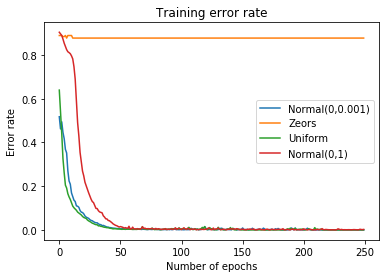

In [49]:
# training_error
plt.plot(L3_a.training_error, label = "Normal(0,0.001)")
plt.plot(L_z.training_error, label = "Zeors")
plt.plot(L_U.training_error, label = "Uniform")
plt.plot(L3_aN.training_error, label = "Normal(0,1)")
plt.legend()
plt.xlabel("Number of epochs")
plt.ylabel("Error rate")
plt.title("Training error rate")
plt.show()

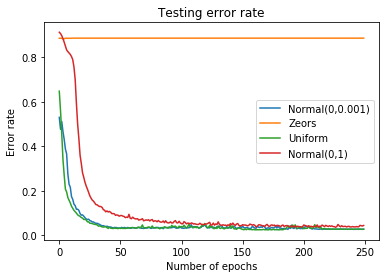

In [50]:
# testing_error
plt.plot(L3_a.testing_error, label = "Normal(0,0.001)")
plt.plot(L_z.testing_error, label = "Zeors")
plt.plot(L_U.testing_error, label = "Uniform")
plt.plot(L3_aN.testing_error, label = "Normal(0,1)")
plt.legend()
plt.xlabel("Number of epochs")
plt.ylabel("Error rate")
plt.title("Testing error rate")
plt.show()

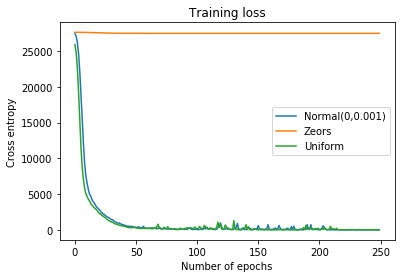

In [87]:
# training_loss
plt.plot(L3_a.training_loss, label = "Normal(0,0.001)")
plt.plot(L_z.training_loss, label = "Zeors")
plt.plot(L_U.training_loss, label = "Uniform")
plt.legend()
plt.xlabel("Number of epochs")
plt.ylabel("Cross entropy")
plt.title("Training loss")
plt.show()

# Question iii

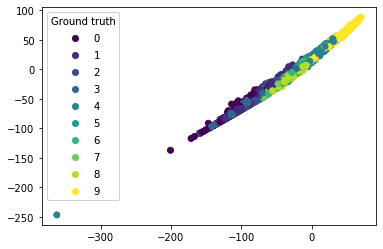

In [29]:
plot_latent_features(X_test[0:2000], y_test[0:2000], DNN_epoch_20, leakyReLU)

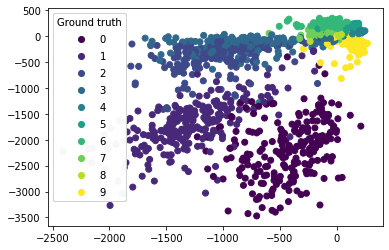

In [33]:
plot_latent_features(X_test[0:2000], y_test[0:2000], DNN_epoch_80, leakyReLU)

# Question iv

In [88]:
cfm(X_test, y_test, L4_a)

     0    1    2    3    4    5    6    7    8    9
0  660    2    2    0    0    0    0    0    0    0
1    4  655    2    0    0    0    0    0    0    0
2    2    4  554   21    2    0    0    0    0    1
3    0    0   32  562    1    2    1    0    2    0
4    1    0    0    1  627    1    1    0    6   14
5    0    0    0    0    1  401    2    2    0    1
6    0    0    0    0    2    1  496    2    0    1
7    1    0    2    2    2    2    4  435    0    1
8    0    0    0    0    4    1    2    0  565    0
9    0    0    2    1   20    0    2    2    1  650
Accuracy:  0.9717406380027739
